# Building the Disaster Tweets Model
### To solve the problem of possibly not all tweets being information regarding Natural Disasters.
### The dataset is from kaggle's "Real or Not? NLP with Disaster Tweets" competition since the aims are almost identical.

In [1]:
import numpy as np
import pandas as pd

In [2]:
train = pd.read_csv('tweets_train.csv')
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
train.shape

(7613, 5)

In [4]:
# Only relevant features from the dataset are the texts, which will be used as the corpus, and the target.
# A target value of 1 indicates the text is indeed related to a Disaster, while 0 states otherwise.

corpus = train['text'].to_list()
labels = train['target'].to_list()
corpus[:10]

['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
 'Forest fire near La Ronge Sask. Canada',
 "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
 '13,000 people receive #wildfires evacuation orders in California ',
 'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ',
 '#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires',
 '#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas',
 "I'm on top of the hill and I can see a fire in the woods...",
 "There's an emergency evacuation happening now in the building across the street",
 "I'm afraid that the tornado is coming to our area..."]

In [5]:
# As expected, the corpus will need some cleaning....
import re
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

In [6]:
# The clean_text function will try it's best to handle the preprocessing. It'll remove stopwords, common
# abbreviations, links to webpages and symbols which are irrelevant to the model.
# Also, added a tokenizer.
# Added a few other words to the stopwords because they had high frequencies without actually meaning much

stop_words = set(stopwords.words('english'))
stop_words.update(['thi', 'amp', 'wa', 'via', 'ha', 'us', 'will', 'new', "n't", 'like', '\n'])

def clean_text(text):
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"[-()\"#/&@;:<>{}+=~|.?,]", "", text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"https\S+", "", text)
    text = re.sub(r"û", "", text)

    word_tokens = word_tokenize(text) 
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    filtered_sentence = [] 

    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w) 

    return ' '.join(filtered_sentence)

In [7]:
clean_corpus = []
for text in corpus:
    clean_corpus.append(clean_text(text))

In [8]:
# The corpus looks a lot better now
clean_corpus[:10]

['deeds reason earthquake may allah forgive',
 'forest fire near la ronge sask canada',
 "residents asked 'shelter place ' notified officers evacuation shelter place orders expected",
 '13000 people receive wildfires evacuation orders california',
 'got sent photo ruby alaska smoke wildfires pours school',
 'rockyfire update california hwy 20 closed directions due lake county fire cafire wildfires',
 'flood disaster heavy rain causes flash flooding streets manitou colorado springs areas',
 'top hill see fire woods',
 "'s emergency evacuation happening building across street",
 'afraid tornado coming area']

In [9]:
# Good way of knowing what kind of corpus we're dealing with is using the WordCloud package to check which words
# have the highest frequencies

from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [10]:
# Split the corpus between texts that indicate Disasters and texts which do not indicate Disasters to get some
# insight from the WordCloud of each of them.
# The list 'real' stores Disaster texts, while 'not_real' stores the opposite

real = []
not_real = []
for i in range(len(clean_corpus)):
    if labels[i] == 1:
        real.append(clean_corpus[i])
    else:
        not_real.append(clean_corpus[i])

In [11]:
real_wc = WordCloud(stopwords=stop_words).generate(' '.join(real))
not_real_wc = WordCloud(stopwords=stop_words).generate(' '.join(not_real))

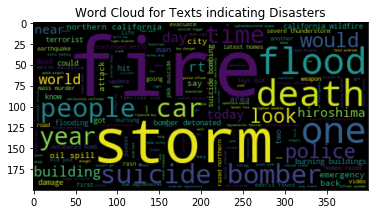

In [12]:
# As expected, the WordCloud for texts inidicating Disasters shows there's a strong frequency for words like 'fire',
# 'flood', 'storm', 'death' and the rest

plt.title('Word Cloud for Texts indicating Disasters')
plt.imshow(real_wc, interpolation='bilinear')

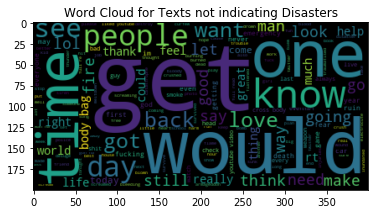

In [13]:
# From this WordCloud, there isn't a particular theme with the words with high frequencies, which isn't bad. Major thing
# is it does not have words that can be likened to Disasters.

plt.title('Word Cloud for Texts not indicating Disasters')
plt.imshow(not_real_wc, interpolation='bilinear')

### Good thing about the visualization was it helped find more stopwords in the corpus.
### I'll stick to the classic TfidfVectorizer for the NLP

In [14]:
# It'll be a lot easier in the workflow to add the preprocessing part to the pipeline for the model.
# So, the TextPreprocessor class is a transformer that will used the clean_text function for cleaning the texts
# It accepts an array of texts and returns the cleaned version of the texts

from sklearn.base import BaseEstimator, TransformerMixin

class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        clean_X = []
        for text in X:
            clean_X.append(clean_text(text))
            
        return clean_X

In [15]:
# Here, does the same function as the clean_text function. Only now I can include it into the model's pipeline

text_prep = TextPreprocessor()
text_prep.fit_transform(corpus[:10])

['deeds reason earthquake may allah forgive',
 'forest fire near la ronge sask canada',
 "residents asked 'shelter place ' notified officers evacuation shelter place orders expected",
 '13000 people receive wildfires evacuation orders california',
 'got sent photo ruby alaska smoke wildfires pours school',
 'rockyfire update california hwy 20 closed directions due lake county fire cafire wildfires',
 'flood disaster heavy rain causes flash flooding streets manitou colorado springs areas',
 'top hill see fire woods',
 "'s emergency evacuation happening building across street",
 'afraid tornado coming area']

In [16]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

In [17]:
# The model pipeline has three models inside it; The text preprocessor, the vectorizer for quantizing the words and
# the classifier. Always safe using MultinomialNB for text classification.
# I set the ngram_range to (1, 2) because it improved the model's preformance, though only slightly.

pipe = Pipeline([('text_preprocessor', TextPreprocessor()), 
                 ('vectorizer', TfidfVectorizer()), 
                 ('classifier', MultinomialNB())])

In [18]:
# I want to get the parameters of each model inside the pipe to know which of them I'd be tuning using 
# the GridSearchCV model.

pipe.get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
         steps=[('text_preprocessor', TextPreprocessor()),
                ('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classifier',
                 MultinomialNB(alpha=1.

In [19]:
# Most attractive parameters for tuning are the ngram_range and alpha paremeters.

param_grid = {'vectorizer__ngram_range': [(1, 1), (1, 2)],
              'classifier__alpha': np.logspace(-2, 3, 10)}

gs = GridSearchCV(pipe, param_grid, n_jobs=5, cv=2, verbose=1)

In [20]:
# Don't want to tune the parameters on the whole corpus to avoid possible overfitting, so I'll use just a subset

X_gs, _, y_gs, _ = train_test_split(corpus, labels, test_size=0.45, shuffle=True)

In [21]:
gs.fit(X_gs, y_gs)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 out of  40 | elapsed:  1.7min finished


GridSearchCV(cv=2, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('text_preprocessor',
                                        TextPreprocessor()),
                                       ('vectorizer',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
      

In [22]:
# Best parameters for the model are....

gs.best_params_

{'classifier__alpha': 1.6681005372000592, 'vectorizer__ngram_range': (1, 2)}

In [23]:
# Before training the model on the sull dataset I'd like to see how it does on a subset

X_train, X_test, y_train, y_test = train_test_split(corpus, labels, test_size=0.2, shuffle=True)

In [24]:
test_model = gs.best_estimator_
test_model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('text_preprocessor', TextPreprocessor()),
                ('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classifier',
                 MultinomialNB(alpha=1.6681005372000592, class_prior=None,
 

In [25]:
# Not perfect but not all bad

test_model.score(X_test, y_test)

0.7767564018384767

In [26]:
# Now to train the fine-tuned model on the full dataset....

model = gs.best_estimator_
model.fit(corpus, labels)

Pipeline(memory=None,
         steps=[('text_preprocessor', TextPreprocessor()),
                ('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classifier',
                 MultinomialNB(alpha=1.6681005372000592, class_prior=None,
 

In [27]:
# Trying the model out myself...
# I think that's decent at the very least if I do say so myself

model.predict(['I had a lot of fun yesterday',
               'There is an earthquake at the station',
               'There were no casualties from the recent flood'])

array([0, 1, 1])

In [28]:
# Now that's done I'll save the model as a gzip file

import gzip
import dill

In [29]:
# Things to note: The model is a bit strict, so it may not allow all disaster tweets, especially the "light"ones
# But it will allow the majority, and it'll do a pretty good job restricting non-disaster tweets.
# I think it's better the model is strict instead of more loose.
# Also, it's far from perfect, but isn't a bad baseline model. I think a way of improving the model is changing the
# corpus and training the model the headlines from the News website. That'd mean just taking headlines from the website
# every day. Also, exploring other models, like NNs isn't a bad idea, but I tried and didn't see much reward in them
# I'll still be looking for how to improve it though, but for now a decent start.

with gzip.open('disaster_text_model.dill.gz', 'wb') as f:
    dill.dump(model, f, recurse=True)